In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

# 第8回 モンテカルロ法1


## モンテカルロ法の基礎

モンテカルロ法の理論的根拠は**大数の法則**である。

---

**大数の法則**

$X_1, X_2, \dots$を互いに独立で同一の分布にしたがう確率変数とする。
$E[X_1] = \mu (< \infty),\ V[X_1] < \infty$ ならば

$$
  \frac{1}{n}\sum_{i=1}^{n}X_i \to \mu\ \text{a.s.} \
	\text{as}\ n	\rightarrow \infty. \quad (概収束)
$$

---

$X_1, X_2, \dots, X_n$を互いに独立で$X$と同一の分布にしたがう $n$ 個の確率変数とし
(これを$X_1,X_2,\dots,X_n$は$X$からの無作為標本であるという)、
$E[X] = \mu$とおく。
このとき、$X_1,X_2,\dots,X_n$ の標本平均

$$
\bar{X}_n = \frac{1}{n}\sum_{i=1}^{n}X_i  \tag{1}
$$

を$\mu$の推定量(確率変数)とする。
大数の法則より

$$ 
	\bar{X}_n \rightarrow
	 \mu\ \text{a.s.}\quad \text{as}\ n \rightarrow \infty
$$

となるから、十分大きい$n$に対して$\bar{X}_n$を計算し、それを$E[X]$の近似値とすればよいと考えられる。

推定量(1)は推定量のよさの基準の1つである不偏性を満たす。
実際、

$$
	E[\bar{X}_n] = \frac{1}{n}\sum_{i=1}^{n}E[X_i] = \mu
$$

である。

$\bar{X}_n$の平均二乗誤差（標準偏差）$e$を計算する。

$$
	e^2 = E[(\bar{X}_n - \mu)^2]
	 = V\left[\frac{1}{n}\sum_{i=1}^{n}X_i\right]
	 =  \frac{1}{n^2}\sum_{i=1}^{n}V\left[X_i\right]
	 = \frac{1}{n^2} \cdot n \sigma_X^2
	 = \frac{\sigma_X^2}{n}
$$

となる。ここで、$\sigma_X = V[X_1]$である。

すなわち，

$$
	e = \frac{\sigma_X}{\sqrt{n}}
$$

が平均二乗誤差となる。
これより、誤差は$O({1}/\sqrt{n})$のオーダーで減少することが分かる。
実際には$X$の標準偏差$\sigma_X$は未知なので、標本標準偏差で置き換えて誤差を計算する。

また、モンテカルロ法による誤差のオーダーは確率変数$X$の次元に依存せず、常に$O({1}/\sqrt{n})$であることが知られている。誤差が次元に依存しないことが、モンテカルロ法の利点の一つである。

つぎのプログラムでモンテカルロ法の誤差が$O({1}/\sqrt{n})$のオーダーで減少することを見る。

In [2]:
def BScall(S, K, T, r, sigma):
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T)/(sigma * np.sqrt(T))
  d2 = d1 - sigma * np.sqrt(T)
  C = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
  return C

def MCBScall(N, S0, K, T, r, sigma):
  np.random.seed(123)
  rnd = np.random.standard_normal(N)  
  S = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * rnd) 
  X = np.exp(-r * T) * np.maximum(S - K, 0) 
  return X.mean()

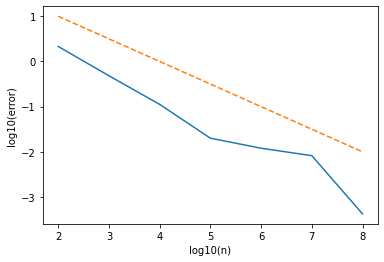

In [3]:
#誤差の計算
S0 = 100
K = 99
T = 1
r = 0.01
sigma = 0.2

N = 9
error = np.zeros(N - 2)
for i in range(2, N):
  error[i - 2] = np.abs(MCBScall(10**i, S0, K, T, r, sigma) - BScall(S0, K, T, r, sigma))

#グラフの描画
log_error = np.log10(error)
x = np.arange(2, 9)
y = -0.5 * x + 2
plt.xlabel('log10(n)')
plt.ylabel('log10(error)')
plt.plot(x, log_error)
plt.plot(x, y, ls='--')
plt.show()

標本数を$n=10^N$（$N=2, \dots, 8$）としたときの、誤差のグラフ。
横軸が $\log_{10}n = N$、縦軸が$\log_{10}(\text{誤差})$。オレンジ色の破線は傾きが$-1/2$の直線。

## 分散減少法

確率変数$X$の期待値$E[X]$をモンテカルロ法で計算するとき、その誤差は

$$
	\frac{\sigma_X}{\sqrt{n}}
$$

で計算できた。
$n$は標本数、$\sigma_X$は$X$の標準偏差。
通常は$\sigma_X$は$X$の標本標準偏差とする。
$\sigma_X$を小さくする方法を**分散減少法**とよぶ。
$\sigma_X$は所与なので小さくすることはできず、
実際には$E[X] = E[Y]$かつ$\sigma_X > \sigma_Y$となる確率変数$Y$を作って、$E[X]$の代わりに$E[Y]$の値を求めようとする。



### 制御変数法
確率変数$X$の期待値$E[X]$をモンテカルロ法により求めることを考える。
いま、別の確率変数$Y$の期待値$E[Y]$が計算できているとする
(解析解による正確な値のほうがよいが、近似値でも構わない）。
このとき$(X_i, Y_i)$($i=1,2,\dots,n$)を$(X,Y)$の無作為標本したときに、
適当な定数$b$に対して

$$
	X_i(b) = X_i - b(Y_i - E[Y])
$$

という変数を作る。
$X_i(b)$ ($i=1,2,\dots,n$)の標本平均は

$$
	\bar{X}(b) = \frac{1}{n}\sum_{i=1}^{n}X_i(b)
	 = \frac{1}{n}\sum_{i=1}^{n}(X_i - b(Y_i - E[Y]))
	 = \bar{X} - b(\bar{Y} - E[Y])
$$

となる。

$\bar{X}(b)$は$E[X]$の不偏推定量である。
実際、

$$
	E[\bar{X}(b)] = E[\bar{X} - b(\bar{Y} - E[Y])] = E[\bar{X}]
	 = E[X]\ （\bar{X}はXの不偏推定量）
$$

である。

ここで、$b$を上手く決めることによって${X}(b)$の分散が${X}$よりも小さくなるようにしたい。
まず、${X_i}(b)$の標準偏差$\sigma_X(b)$を計算すると

$$
\sigma_X^2(b)=V[{X_i(b)}] = V[X_i - b(Y_i - E[Y])]
 = V[X_i] + V[b(Y_i - E[Y])] -2b\mathrm{Cov}(X_i, Y_i - E[Y]) 
 = \sigma_X^2 + b^2 \sigma_Y^2 - 2b \sigma_X \sigma_Y \rho_{XY} \tag{2}
$$

となる。
ここで、$\sigma^2_X = V[X], \sigma^2_Y = V[Y]$, $\rho_{XY}$は
$X,Y$の相関係数である。
よって、

$$
b^2 \sigma_Y^2 -  2b\sigma_X\sigma_Y\rho_{XY} \leq 0 \
       \Leftrightarrow\
       \begin{cases}
       	0 < b < \frac{2\sigma_X}{\sigma_Y}\rho_{XY},\ & \rho_{XY} > 0\\
	\frac{2\sigma_X}{\sigma_Y}\rho_{XY} < b < 0,\ & \rho_{XY} <0
       \end{cases}
$$

であれば$\sigma_X(b) < \sigma_X$
となる。
このときは、$\bar{X}$の代わりに$\bar{X}(b)$を計
算した方が誤差が小さい。

また、

$$
b^* = \frac{\sigma_X}{\sigma_Y}\rho_{XY} = \frac{\mathrm{Cov(X,Y)}}{V[Y]}
$$

としたときに$\sigma_X(b)$は最も小さくなる。
$V[X(b^*)]$と$V[X]$を比べてみると

$$
\frac{V[{X}(b^*)]}{V[{X}]} =
\frac{\sigma_X^2(1-\rho_{XY}^2)}{\sigma_X^2}
	 = 1- \rho_{XY}^2.
$$

よって、$X$と$Y$の相関が$1$または$-1$に近いほど分散の減少効果が得られることになる。

この$Y$を**制御変数**とよぶ。
制御変数$Y$には$X$と同じような動きをするものを選ぶ。
$b^*$は通常は未知なので、標本から得られる値で置き換える。
すなわち、

$$ \tag{3}
	b_n = \frac{\sum_{i=1}^{n}(X_i - \bar{X})(Y_i -
	 \bar{Y})}{\sum_{i=1}^{n}(Y_i - \bar{Y})^2}
$$

で置き換える。
じつは(3)は標本$(X_1, \dots, X_n)$を$(Y_1, \dots, Y_n)$に回帰したときの回帰係数に他ならない。

制御変数法の効果を見るため、
Black-Scholesモデルにおいてヨーロピアンコールオプションの価格を求めてみる。
求めたい値は$E[e^{-rT}(S(T) - K)^+]$で、
制御変数を原資産価格$S(T)$とする。
対数正規分布の計算から

$$
	E[S(T)] = e^{rT}S(0)
$$

であることを使う。

---
（参考）
$X \sim N(\mu, \sigma^2)$のとき、$Y=e^X$（対数正規分布に従う）の期待値と分散は

$$
E[Y] = e^{\mu + \sigma^2/2},\ V[Y] = (e^{\sigma^2} - 1)e^{2\mu+\sigma^2}
$$

となる。

----

よって、

$$
	\frac{1}{n}\sum_{i=1}^{n}\left[e^{-rT}(S^i(T) - K)^+ - b^*(S^i(T) - e^{rT}S(0))\right]
$$

として、$E[e^{-rT}(S(T) - K)^+]$を計算する。
ここで、$S^i(T)$ ($i=1,2,\dots,n$)は$S(T)$と同じ分布をもつ無作為標本である。




In [4]:
def CVBScall(N, S0, K, T, r, sigma):
  np.random.seed(123)
  rnd = np.random.standard_normal(N)  #正規乱数
  S = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * rnd) #株価の値、制御変数
  X = np.exp(-r * T) * np.maximum(S - K, 0) #支払いの現在価値の標本
  covXS = np.cov(X, S)[0, 1]
  b = covXS / np.var(S)
  Xb = X - b * (S - np.exp(r * T) * S0)  #Xから制御変数を引いたもの
  return Xb.mean()

In [5]:
CVBScall(10000, 100, 99, 1, 0.01, 0.2)

8.914374608253311

収束の様子を観察してみる。標本数を $10000 \times i$（$i=1, 2, \dots, N$)として、価格のグラフを描く。

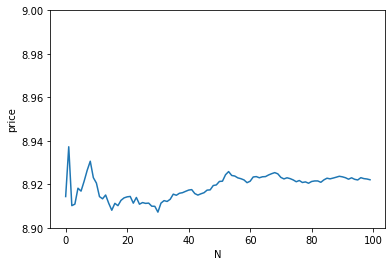

In [6]:
# 制御変数変数法を使ったオプション価格
N = 100
price = np.zeros(N)
for i in range(N):
  price[i] = CVBScall(10000 * (i + 1), 100, 99, 1, 0.01, 0.2)

# グラフ
plt.ylim(8.9, 9.0)
plt.xlabel('i')
plt.ylabel('price')
plt.plot(price)
plt.show()

　制御変数法を使わない場合と比較してみる。

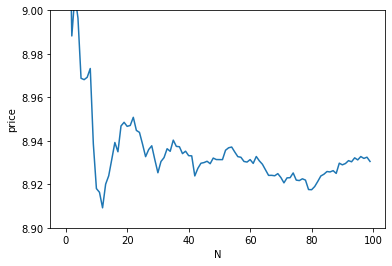

In [7]:
N = 100
price2 = np.zeros(N)
for i in range(N):
  price2[i] = MCBScall(10000 * (i + 1), 100, 99, 1, 0.01, 0.2)

# グラフ
plt.ylim(8.9, 9.0)
plt.xlabel('i')
plt.ylabel('price')
plt.plot(price2)
plt.show()

### 対称変数法

確率変数

$$
S(T) = S(0)\exp\left\{\left(r-\frac{\sigma^2}{2}\right)T + \sigma W(T)\right\}
$$

と同じ分布をもつ$n$個の無作為標本を得るには正規乱数

$$
Z_1, Z_2, \dots, Z_n  \tag{4}
$$

を発生させ、

$$
S^i = S(0)\exp\left\{\left(r-\frac{\sigma^2}2\right)T + \sigma \sqrt{T}Z_i\right\}
$$

とすればよかった。

このとき、同時に

$$
	-Z_1, -Z_2, \dots, -Z_n  \tag{5}
$$

を乱数として

$$
\tilde{S}_i = S(0)\exp\left\{\left(r-\frac{\sigma^2}2\right)T + \sigma \sqrt{T}(-Z_i)\right\}
$$

という標本も作る。

(4)と(5)の乱数は$-1$の相関を持っているので、
$S_i$と${\tilde{S}_i}$はかなり強い負の相関を持つことが予測できる。
そこで$E[X]$ ($X=h(S(T))$)を計算する際に

$$
\bar{X}_A = \frac{1}{2n}\left(\sum_{i=1}^nX_i + \sum_{i=1}^n\tilde{X}_i\right)
$$

を$E[X]$の推定量とする。
ここで、$X_i = h(S_i),\ \tilde{X}_i = h(\tilde{S}_i)$である。
これは明らかに不偏推定量である。
この手法を**対称変数法**とよぶ。

いま標本$X_i$を生成するタイミングで$\tilde{X}_i$も生成すると仮定すると、
対称変数法が意味を持つのは

$$
	V[\bar{X}_A] < V\left[\frac{1}{2n}\sum_{i=1}^{2n}X_i\right]
$$

のとき、すなわち

$$
	V[X_i + \tilde{X}_i] < 2V[X_i]
$$

のときだと言える。
この式の左辺は

$$
	V[X_i + \tilde{X}_i]
	 = V[X_i] + V[\tilde{X}_i] + 2 \mathrm{Cov}(X_i,
	 \tilde{X}_i)
	 = 2V[X_i]+ 2 \mathrm{Cov}(X_i, \tilde{X}_i)
$$

であるから、

$$
	\mathrm{Cov}(X_i,\tilde{X}_i) < 0
$$

のとき、すなわち$X_i$と$\tilde{X}_i$の相関が負のとき、対象変数法に分散減少効果があることが分かる。

Black-Scholesモデルにおいてヨーロピアンコールオプションの価格を対称変数法を用いて求める。

In [8]:
def AntBScall(N, S0, K, T, r, sigma):

  np.random.seed(123)
  rnd = np.random.standard_normal(N)

  #満期における株価を生成
  S = S0 * np. exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * rnd)
  #対称変数法により満期における株価を生成
  Sm = S0 * np.exp((r - 0.5 * sigma**2)*T + sigma * np.sqrt(T) * (-rnd))

  X = np.exp(-r * T) * np.maximum(S - K, 0)   #Sに対する支払い
  Xm = np.exp(-r * T) * np.maximum(Sm - K, 0)  #Smに対する支払い

  return (X.mean() + Xm.mean())/2


In [9]:
AntBScall(100000, 100, 99, 1, 0.01, 0.2)

8.921681947013795

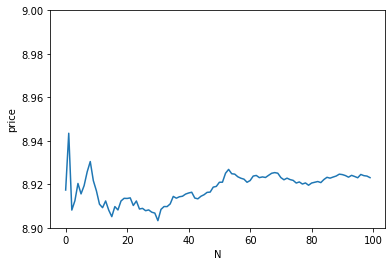

In [10]:
# 制御変数変数法を使ったオプション価格
N = 100
price3 = np.zeros(N)
for i in range(N):
  price3[i] = AntBScall(10000 * (i + 1), 100, 99, 1, 0.01, 0.2)

# グラフ
plt.ylim(8.9, 9.0)
plt.xlabel('i')
plt.ylabel('price')
plt.plot(price3)
plt.show()

**演習問題**
$T$時点における株価$S(T)$がBlack-Scholesモデルにしたがうとする。このとき 

$$
I\{S(T) > K\}
$$

という支払いを持つオプションの価格

$$
E[e^{-rT}I\{S(T) > K\}]
$$

をモンテカルロ法により計算せよ。何らかの分散減少法を適用すること。

ここで $I\{\}$は$\{ \}$内の条件が満たされたとき$1$、そうでないとき$0$の値を取る関数である。すなわち、

$$
Tにおける支払い = 
\begin{cases}
1,\ \text{if}\ S(T) > K\\
0,\ \text{if}\ S(T) \leq K
\end{cases}
$$

である。

In [11]:
def AntDigitcall(N, S0, K, T, r, sigma):

  np.random.seed(123)
  rnd = np.random.standard_normal(N)

  #満期における株価を生成
  S = S0 * np. exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * rnd)
  #対称変数法により満期における株価を生成
  Sm = S0 * np.exp((r - 0.5 * sigma**2)*T + sigma * np.sqrt(T) * (-rnd))

  X = np.exp(-r * T) * (S > K)   #Sに対する支払い
  Xm = np.exp(-r * T) * (Sm > K)  #Smに対する支払い

  return (X.mean() + Xm.mean())/2

In [12]:
AntDigitcall(100000, 100, 99, 1, 0.01, 0.2)

0.4951437228546339